In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import pandas as pd

import matplotlib.animation as animation
import IPython

import torch.distributions as tdist

from ipywidgets import interact

from utils import *
from variational_inference_classes import *

%load_ext autoreload
%autoreload 2

$\newcommand{\elbo}{\mathrm{ELBO}}$
$\newcommand{\kl}{\mathrm{KL}}$
$\newcommand{\set}[1]{ \left\{ #1 \right\}}$
$\def\R{{\mathbb R}}$
$\def\Q{{\mathbb Q}}$
$\def\E{{\mathbb E}}$
$\def\C{{\mathbb C}}$
$\def\N{{\mathbb N}}$
$\def\Z{{\mathbb Z}}$

$\newcommand{\brac}[1]{\left(#1\right)}$
$\newcommand{\abs}[1]{\left|\, #1\,\right|}$
$\newcommand{\p}{\partial}$
$\newcommand{\abrac}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\sqbrac}[1]{\left[ #1 \right]}$
$\newcommand{\st}{\, \, : \,}$
$\newcommand{\supp}{\mathrm{supp}}$
$\newcommand{\norm}[1]{\lVert #1 \rVert}$
$\renewcommand{\d}[1]{\, \mathrm{d}#1 \,}$

# Unit tests (Making sure that code works as intended)

## Unit test 1: Gaussian family VI to learn known Gaussian posterior
Will try to do variational inference against toy Gaussian posterior to make sure that the code has intended behaviour. 

We will attempt to approximate the normal distribution 
$$
p(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma_0^2I_d)}} e^{\frac{1}{2\sigma_0^2}\sum_{j = 1}^d (\xi_j - \mu_{0j})^2}. 
$$

We shall find a distribution from the following Gaussian family
$$
\mathcal{Q}_{gaussian} = \set{q_{\mu, \sigma}(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma^2I_d)}} e^{\frac{1}{2\sigma^2}\sum_{j = 1}^d (\xi_j - \mu_{j})^2} \st \mu \in \R^d, \sigma \in \R_{> 0}}
$$


In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{e^{-\frac{1}{2\sigma_0^2}\sum_j (\xi_j - \mu_{0j})^2}}} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

Epoch     0: mu=[0.1 0.9], sigma=0.899, elbo=-1.93
Epoch   100: mu=[0.19 0.8 ], sigma=0.818, elbo=-1.04
Epoch   200: mu=[0.27 0.72], sigma=0.754, elbo=-0.63
Epoch   300: mu=[0.34 0.64], sigma=0.703, elbo=-0.26
Epoch   400: mu=[0.39 0.57], sigma=0.662, elbo=0.09
Epoch   500: mu=[0.43 0.51], sigma=0.628, elbo=0.29
Epoch   600: mu=[0.45 0.46], sigma=0.602, elbo=0.37
Epoch   700: mu=[0.47 0.42], sigma=0.580, elbo=0.36
Epoch   800: mu=[0.48 0.39], sigma=0.562, elbo=0.45
Epoch   900: mu=[0.49 0.36], sigma=0.548, elbo=0.43


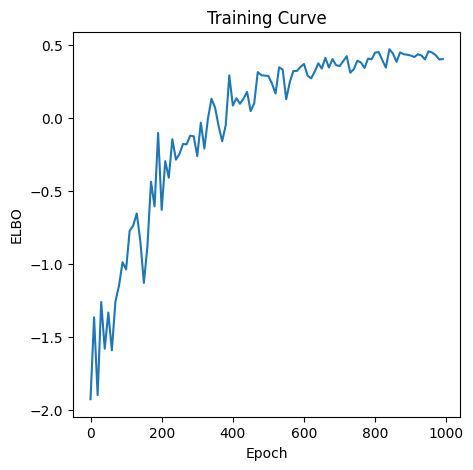

In [2]:
gaussian_vi = GaussianFamilyOn2DGaussianPosterior(
    mu_0=torch.tensor([0.5, 0.3]), 
    sigma_0=torch.tensor([0.5])
)
gaussian_vi.run_parameter_optimisation(1000)
fig = gaussian_vi.plot_training_curve();

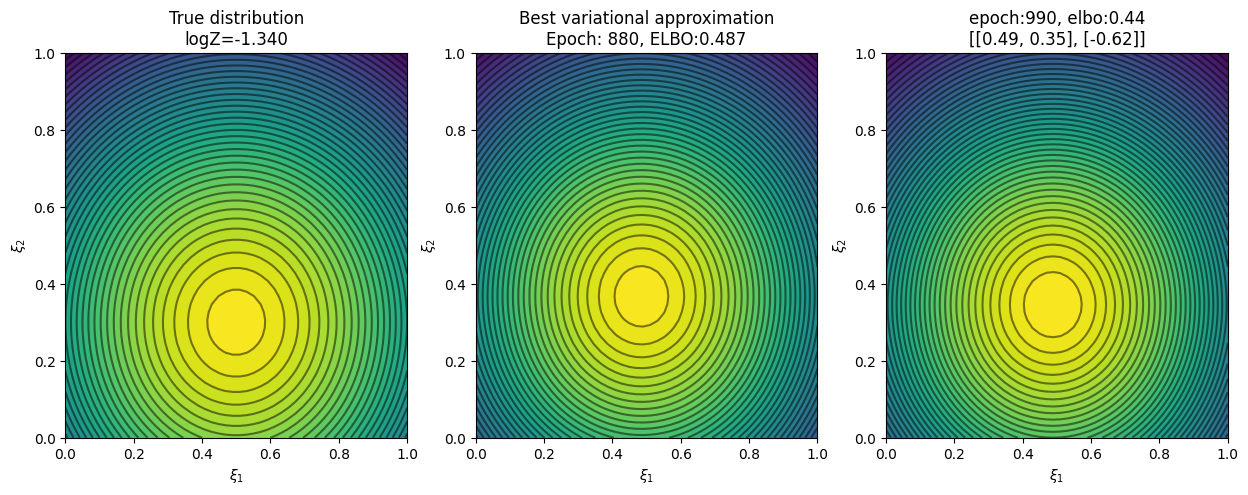

In [17]:
fig, video = gaussian_vi.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


## Unit test 2: Mean field generalised gamma family to learn mean field generalised gamma

Here we try to use a mean-field generalised gamma family to learn a known generalised gamma distribution: 
$$
p(\xi) = \prod_{j = 1}^2 \frac{\beta_{0j}^{\lambda_{0j}}}{\Gamma(\lambda_{0j})} \xi_j^{2k_{0j}\lambda_{0j} - 1} e^{-\beta_{0j}\xi_j^{2k_{0j}}}
$$

The mean-field generalised gamma variational family is given by
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}}
$$

In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{\prod_{j = 1}^2 \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} }} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

In [4]:
# TODO

# Experiment 1: Learning 2D standard form posterior 

## Experiment 1.0: Learning with Gaussian Family

We are assuming that our posterior is of the form 
$$
p(\xi_1, \xi_2) = \frac{1}{\overline{Z}_n} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}, \quad (\xi_1, \xi_2) \in [0, 1]^2
$$
where $\overline{Z}_n = \int_{[0, 1]^2} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}} d\xi_1 d\xi_2$ is the normalising constant, a.k.a. the evidence.  

The posterior contours would look like the following:

In [130]:
N = 200
a, b = 0, 1
xx, yy = np.meshgrid(np.linspace(a, b, num=N), np.linspace(a, b, num=N))
w = np.stack((xx, yy), axis=-1)

@interact(
    n=(2, 100000),
    k1=(0, 5),
    k2=(0, 5),
    h1=(0, 5),
    h2=(0, 5)
)
def _plot_contour(n=500, k1=2, k2=3, h1=1, h2=2):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    h = np.array([h1, h2])
    k = np.array([k1, k2])
    boltzman_weight = lambda w: np.abs(np.prod(w**h, axis=-1)) * np.exp(-n * np.prod(w ** (2 * k), axis=-1))
    integrand = lambda y, x: boltzman_weight(np.array([x, y]))
    z = boltzman_weight(w)
    evidence = scipy.integrate.dblquad(integrand, 0, 1, 0, 1)

#     z = np.abs(np.prod(w**h, axis=-1)) * np.exp(-n * np.prod(w ** (2 * k), axis=-1))
    normalising_const = np.sum(z) / (N**2)
    lambdas = (h + 1) / (2 * k)
    rlct = np.min(lambdas)
    m = np.sum(lambdas == rlct)
    const_term = (
        scipy.special.loggamma(rlct) 
#         - np.log(scipy.special.factorial(m -1)) 
        - m * np.log(2)
    )
    
    if m == 2: 
        const_term -= np.sum(np.log(k))
    elif m == 1:
        i = np.argmin(lambdas)
        j = np.argmax(lambdas)
        const_term -= np.log(k[i])
        const_term -= np.log(lambdas[j] - lambdas[i])
    
    leading_terms = rlct * np.log(n) - (m -1) * np.log(np.log(n))
    print(
        f"evidence         = {evidence}\n"
        f"-logZ integrated = {-np.log(evidence[0])}\n"
        f"-logZ            = {-np.log(normalising_const)}\n"
        f"RLCT             = {rlct}\n"
        f"m                = {m}\n"
        f"const            = {const_term}\n"
        f"rlct log(n) - (m - 1) log log n         = {leading_terms}\n"
        f"rlct log(n) - (m - 1) log log n - log C = {leading_terms - const_term}\n"
        f"Residue          = {-np.log(evidence[0]) - leading_terms + const_term}\n"
    )
    ax.contourf(xx, yy, z / normalising_const, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$")

interactive(children=(IntSlider(value=500, description='n', max=100000, min=2), IntSlider(value=2, description…

Given a variational family $\mathcal{Q}$, we wish to find a variational approximation $\hat{q} \in \mathcal{Q}$ that minimises the KL-divergence $KL(\hat{q} || p(\xi_1, \xi_2)$. Notice though that this is equivalent to maximising the ELBO = Evidence Lower Bound: 
$$
\elbo(q)= -\E_q\sqbrac{n\xi^{2k}} - \E_q \log \frac{q(\xi)}{\xi^h} \\
$$

This can be shown by the following calculation. 
$$
\begin{align*}
  \kl(q||p) 
  &= \E_q\log \frac{q(\xi)}{p(\xi)}\\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}} \\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
\end{align*}
$$
Since $\kl(q||p) \geq 0$, we can bound the log-evidence with 
$$
  \log \overline{Z}_n \geq -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2} =: \elbo(q)
$$

## Gaussian Variational Family
We shall first use a simple Gaussian family of distribution for variational inference. 
$$
\mathcal{Q}_{gaussian} := \set{q_{\mu_1, \mu_2, \sigma}(\xi) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2} \sqbrac{(\xi_1 - \mu_1)^2 + (\xi_2 - \mu_2)^2}} \st \mu_1, \mu_2 \in \R, \sigma \in (0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\nabla_\theta \elbo(q_\theta) 
  &= \nabla_\theta \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \nabla_\theta \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

Epoch      0: mu=[0.1 0.9], sigma=0.300, elbo=-13.34
Epoch   1500: mu=[0.03 0.71], sigma=0.263, elbo=-10.34
Epoch   3000: mu=[0.02 0.75], sigma=0.246, elbo=-10.89
Epoch   4500: mu=[0.04 0.75], sigma=0.242, elbo=-10.68
Epoch   6000: mu=[0.01 0.77], sigma=0.237, elbo=-10.08
Epoch   7500: mu=[0.03 0.8 ], sigma=0.227, elbo=-10.82
Epoch   9000: mu=[0.08 0.85], sigma=0.210, elbo=-10.23
Epoch  10500: mu=[0.05 0.91], sigma=0.205, elbo=-10.42
Epoch  12000: mu=[0.02 0.98], sigma=0.198, elbo=-9.50
Epoch  13500: mu=[0.04 1.04], sigma=0.181, elbo=-9.35


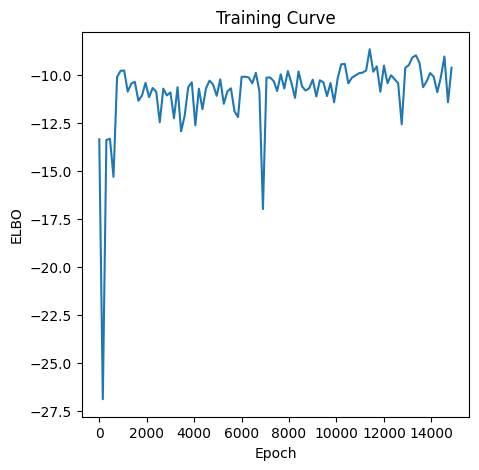

In [124]:
# k_0=torch.tensor([2, 3]), 
# h_0=torch.tensor([1, 2]), 
    
n = 500
k_0 = torch.tensor([3., 4.])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([8/10, 9/10]) # need to ensure the first lambda is the smallest
h_0 = 2 * k_0 * lambda_0 - 1

gaussian_on_standard_form = GaussianFamilyOn2DStandardForm(
    n=500,
    k_0=k_0,
    h_0=h_0, 
    lr=0.001
)

gaussian_on_standard_form.run_parameter_optimisation(15000)
fig = gaussian_on_standard_form.plot_training_curve();

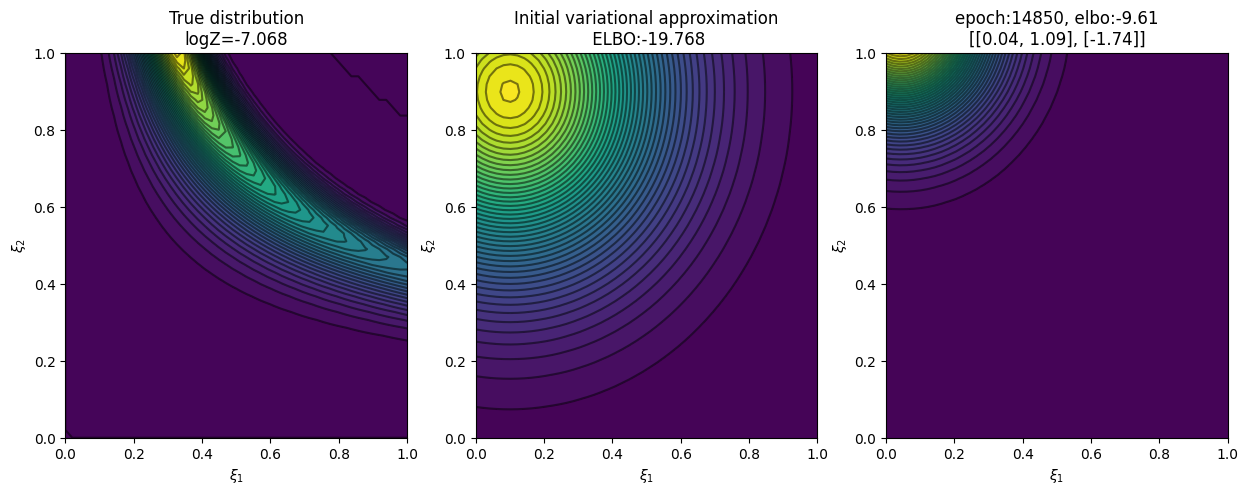

In [125]:
fig, video = gaussian_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


# Experiment 2: Learning 2D standard form with Gamma Mean Field Family

## Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  - \elbo(q_\theta) 
  &= \E_q n \xi_1^{2k_{01}} \xi_2^{2k_{02}} + \E_q\log \frac{q(\xi)}{\xi_1^{h_{01}} \xi_2^{h_{02}}}\\
\end{align*}
$$

The first term is given by (with $d = 2$ below)
$$
\begin{align*}
\E_q n \xi_1^{2k_1} \xi_2^{2k_2}
&= n \prod_{j = 1}^d \int_0^\infty q_j(\xi_j) \xi_j^{2k_{0j}} d\xi_j\\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \int_0^\infty \xi_j^{2k_j \lambda_j +2k_{0j} -1} e^{-\beta_j \xi_j^{2k_j}} d\xi_j \\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \frac{1}{2k_j\beta_j^{\lambda_j + \frac{k_{0j}}{k_j}}}\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}\\
&= n \prod_{j = 1}^d \frac{1}{ \beta_j^{k_{0j} / k_j}}\frac{\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}}{\Gamma(\lambda_j)}
\end{align*}
$$

The second term is given by 
$$
\begin{align*}
\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}}
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{q(\xi_j)}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}}}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \log\brac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} } 
- \beta_j \int_0^\infty q(\xi_j) \xi_j^{2k_j} d\xi_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \beta_j \frac{\beta_j^{\lambda_j}2k_j}{\Gamma(\lambda_j)} \frac{\Gamma(\lambda_j + 1)}{2k_j \beta_j^{\lambda_j + 1}}
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \lambda_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\frac{1}{2k_j}\brac{\psi(\lambda_j) - \log \beta_j}\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda_j)
- \lambda_j
+ \brac{\lambda_j - \frac{k_{0j}}{k_j}\lambda_{0j}}\brac{\psi(\lambda_j) - \log \beta_j}. 
\end{align*}
$$

To evaluate $\E_{q_j}\log \xi_j$, we have use the following observation 
$$
\frac{d}{d\lambda}\Gamma(\lambda) = \int_0^\infty e^{-t} \frac{d}{d\lambda}t^{\lambda -1} dt = \int_0^\infty e^{-t} t^{\lambda -1} \log t dt
$$
and hence, using the substitution $t =\beta \xi^{2k}$
$$
\begin{align*}
\E_{q} \log \xi 
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-\beta \xi^{2k}} \xi^{2\lambda k - 1} \log \xi d\xi\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-t} \brac{\frac{t}{\beta}}^{\lambda - 1/(2k)} \log\brac{\frac{t}{\beta}}^{1/(2k)} \frac{t^{1/(2k) - 1}}{2k\beta^{1/(2k)}} dt\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\frac{1}{4k^2 \beta^\lambda}\int_0^\infty e^{-t} t^{\lambda -1} \brac{\log t - \log \beta}dt\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\int_0^\infty e^{-t} t^{\lambda -1} \log t dt - \log \beta \int_0^\infty e^{-t}t^{\lambda -1} dt}\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\Gamma'(\lambda) - \Gamma(\lambda)\log \beta }\\
&= \frac{1}{2k}\brac{\frac{\Gamma'(\lambda)}{\Gamma(\lambda)} - \log \beta}\\
&= \frac{1}{2k}\brac{\psi(\lambda) - \log \beta}\\
\end{align*}
$$


Note: 
 * It seems like making $\beta$ really large in the above expression maximises the ELBO expression .. This might be a consequence of the fact that the vairational distribution is not absolutely continuous w.r.t. the posterior ...? 
 * But with $n$ large or $\beta$ large, the constribution outside of the unit cube shouldn't matter much ...? 

n        = 1000
lambda_0 = tensor([0.1000, 0.7500])
ks_0     = tensor([7, 5])
h_0      = tensor([0.4000, 6.5000])

logZ=-2.9504
Epoch     0: elbo=-2.40, lambdas=[0.1, 0.75], ks=[7.0, 5.0], betas=[1000.0, 1.0]
Epoch  1000: elbo=-1.80, lambdas=[0.1, 0.75], ks=[7.0, 5.0], betas=[1000.0, 0.38]
Epoch  2000: elbo=-1.44, lambdas=[0.1, 0.75], ks=[7.0, 5.0], betas=[1000.0, 0.17]
Epoch  3000: elbo=-1.35, lambdas=[0.1, 0.75], ks=[7.0, 5.0], betas=[1000.0, 0.11]
Epoch  4000: elbo=-1.35, lambdas=[0.1, 0.75], ks=[7.0, 5.0], betas=[1000.0, 0.1]
Epoch  5000: elbo=-1.35, lambdas=[0.1, 0.75], ks=[7.0, 5.0], betas=[1000.0, 0.1]
Epoch  6000: elbo=-1.35, lambdas=[0.1, 0.75], ks=[7.0, 5.0], betas=[1000.0, 0.1]
Epoch  7000: elbo=-1.35, lambdas=[0.1, 0.75], ks=[7.0, 5.0], betas=[1000.0, 0.1]
Epoch  8000: elbo=-1.35, lambdas=[0.1, 0.75], ks=[7.0, 5.0], betas=[1000.0, 0.1]
Epoch  9000: elbo=-1.35, lambdas=[0.1, 0.75], ks=[7.0, 5.0], betas=[1000.0, 0.1]


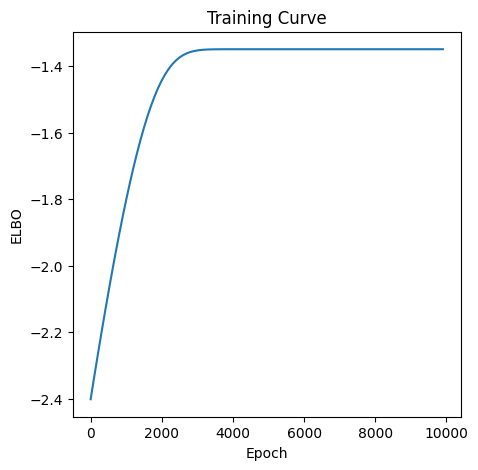

In [23]:
n = 1000
k_0 = torch.tensor([7, 5])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([1/10, 3/4])
h_0 = 2 * k_0 * lambda_0 - 1

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}\n"
)

mean_field_gamma_on_standard_form = MeanFieldGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lambdas_grad=False, 
    ks_grad=False, 
    beta1_grad=False,
)
print(f"logZ={mean_field_gamma_on_standard_form.log_evidence():.4f}")
mean_field_gamma_on_standard_form.run_parameter_optimisation(10000)
mean_field_gamma_on_standard_form.plot_training_curve();

In [16]:
lambdas, ks, beta1, betas_rest = [torch.exp(param).detach() for param in mean_field_gamma_on_standard_form.parameters]
lambda_0, k_0, n = mean_field_gamma_on_standard_form.true_parameters
h_0 = 2 * lambda_0 * k_0 -1
def f(x1, x2):
    w = torch.tensor([x1, x2])
    with torch.no_grad():
        density = mean_field_gamma_on_standard_form.variational_density(
            w, mean_field_gamma_on_standard_form.parameters
        )
    t = standard_form_unnormlised_density(w, k_0, h_0, n)
    return density * (torch.log(density) - torch.log(t))
scipy.integrate.dblquad(f, 1e-3, 1, 1e-3, 1)

(nan, 0)

In [19]:
lambdas, ks, 2 * lambdas * ks -1, beta1, betas_rest

(tensor([ 85.0918, 564.4750]),
 tensor([0.0270, 0.1420]),
 tensor([  3.5954, 159.2593]),
 tensor([1000.0001]),
 tensor([0.0062]))

/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/matplotlib/contour.py:1479: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/edmund/variational-approximation-for-singular-models/notebooks/variational_inference_classes.py:127: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, levels=levels, colors="k", alpha=0.5)
/home/edmund/variational-approximation-for-singular-models/notebooks/variational_inference_classes.py:148: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, levels=levels, colors="k", alpha=0.5)
/home/edmund/.local/share/virtualenvs/variatio

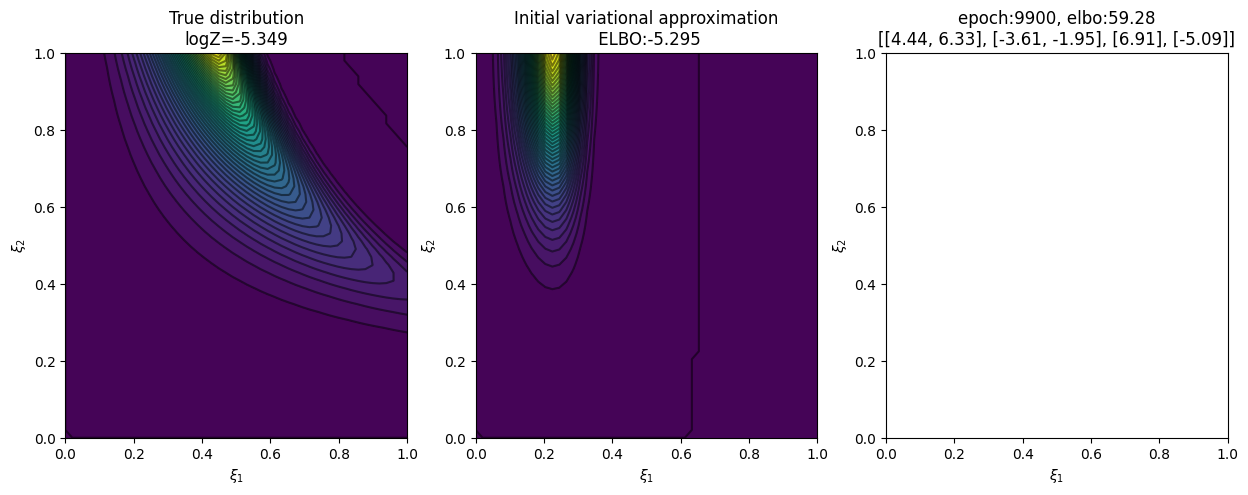

In [83]:
fig, video = mean_field_gamma_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


## Experiment 2.2: Learning 2D standard form with generalised gamma mean-field family optimising only $\beta$

Notes: 
 * It seems like even when the $\lambda$ and $k$ are freezed to the true value, the $\beta$ corresponding to the smallest $\lambda$ goes to $\infty$ while the other one goes to $0$. 

n        = 1000
lambda_0 = tensor([0.4000, 0.7500])
ks_0     = tensor([5, 4])
h_0      = tensor([3., 5.])

Epoch     0: elbo=-5.30, lambdas=[0.4, 0.75], ks=[5.0, 4.0], betas=[1000.0, 1.0]
Epoch   200: elbo=-5.21, lambdas=[0.4, 0.75], ks=[5.0, 4.0], betas=[1000.0, 0.82]
Epoch   400: elbo=-5.15, lambdas=[0.4, 0.75], ks=[5.0, 4.0], betas=[1000.0, 0.69]
Epoch   600: elbo=-5.11, lambdas=[0.4, 0.75], ks=[5.0, 4.0], betas=[1000.0, 0.59]
Epoch   800: elbo=-5.08, lambdas=[0.4, 0.75], ks=[5.0, 4.0], betas=[1000.0, 0.52]
Epoch  1000: elbo=-5.07, lambdas=[0.4, 0.75], ks=[5.0, 4.0], betas=[1000.0, 0.47]
Epoch  1200: elbo=-5.06, lambdas=[0.4, 0.75], ks=[5.0, 4.0], betas=[1000.0, 0.44]
Epoch  1400: elbo=-5.06, lambdas=[0.4, 0.75], ks=[5.0, 4.0], betas=[1000.0, 0.42]
Epoch  1600: elbo=-5.06, lambdas=[0.4, 0.75], ks=[5.0, 4.0], betas=[1000.0, 0.41]
Epoch  1800: elbo=-5.06, lambdas=[0.4, 0.75], ks=[5.0, 4.0], betas=[1000.0, 0.4]


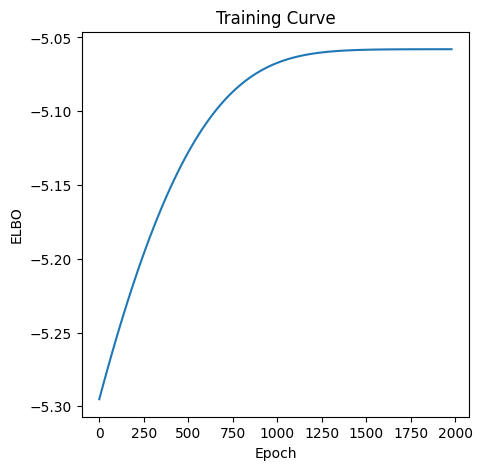

In [63]:
n = 1000
k_0 = torch.tensor([5, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([4/10, 3/4])
h_0 = 2 * k_0 * lambda_0 - 1

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}\n"
)

meanfield_gamma_restricted_on_standard_form = MeanFieldGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lambdas_grad=False, 
    ks_grad=False, 
    beta1_grad=False,
)

meanfield_gamma_restricted_on_standard_form.run_parameter_optimisation(2000)
meanfield_gamma_restricted_on_standard_form.plot_training_curve();

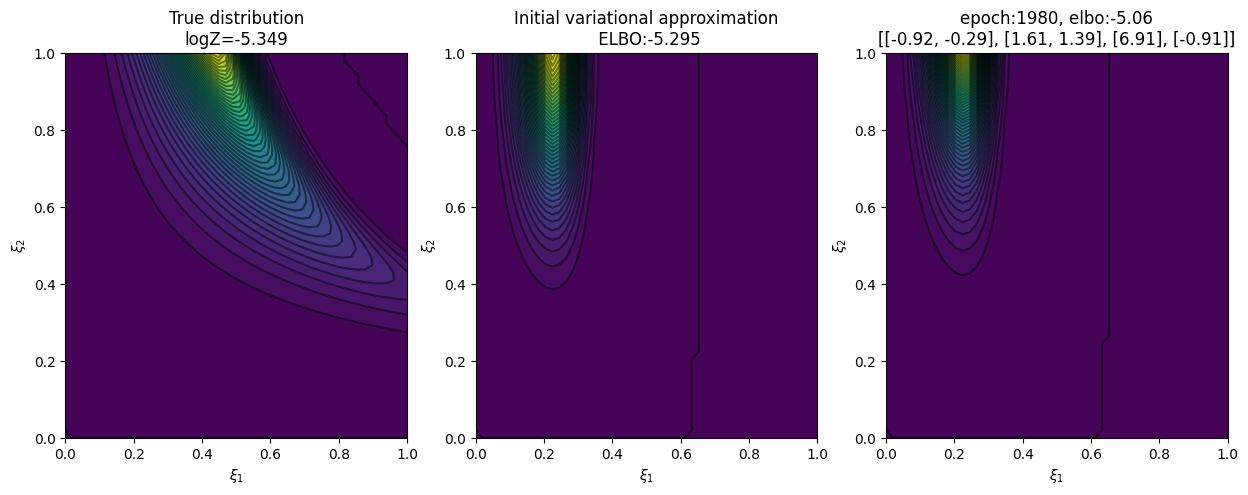

In [64]:
fig, video = meanfield_gamma_restricted_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


# Experiment 3: Learning 2D standard form with Truncated Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of truncated generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, 1)}
$$

n        = 1000
lambda_0 = tensor([0.2300, 0.6600])
ks_0     = tensor([3, 4])
logZ     = -3.258

Epoch     0: elbo=-3.55, lambdas=[0.23, 0.66], ks=[3.0, 4.0], betas=[1000.0, 1.0]
Epoch   800: elbo=-3.47, lambdas=[0.23, 0.66], ks=[3.0, 5.53], betas=[1000.0, 0.35]
Epoch  1600: elbo=-3.26, lambdas=[0.23, 0.66], ks=[3.0, 8.01], betas=[1000.0, 0.15]
Epoch  2400: elbo=-2.72, lambdas=[0.23, 0.66], ks=[3.0, 12.59], betas=[1000.0, 0.08]
Epoch  3200: elbo=-1.84, lambdas=[0.23, 0.66], ks=[3.0, 18.53], betas=[1000.0, 0.05]
Epoch  4000: elbo=-0.56, lambdas=[0.23, 0.66], ks=[3.0, 26.01], betas=[1000.0, 0.03]
Epoch  4800: elbo=1.23, lambdas=[0.23, 0.66], ks=[3.0, 35.49], betas=[1000.0, 0.02]
Epoch  5600: elbo=3.68, lambdas=[0.23, 0.66], ks=[3.0, 47.62], betas=[1000.0, 0.01]
Epoch  6400: elbo=7.01, lambdas=[0.23, 0.66], ks=[3.0, 63.3], betas=[1000.0, 0.01]
Epoch  7200: elbo=11.51, lambdas=[0.23, 0.66], ks=[3.0, 83.72], betas=[1000.0, 0.01]


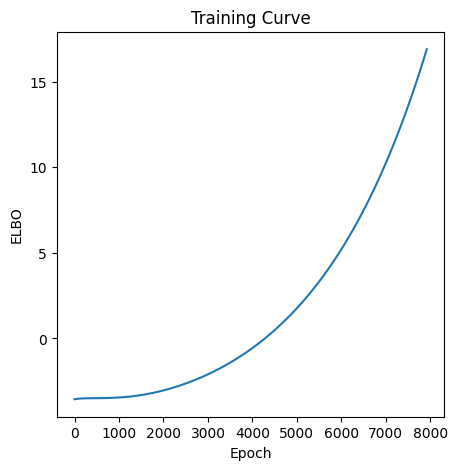

In [122]:
n = 1000
k_0 = torch.tensor([3, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([.23, .66]) # need to ensure the first lambda is the smallest
h_0 = 2 * k_0 * lambda_0 - 1

meanfield_truncated_gamma_restricted_on_standard_form = MeanFieldTruncatedGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.001, 
    lambdas_grad=False, 
    ks_grad=True, 
    beta1_grad=False
)
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)


meanfield_truncated_gamma_restricted_on_standard_form.run_parameter_optimisation(8000)
fig = meanfield_truncated_gamma_restricted_on_standard_form.plot_training_curve();

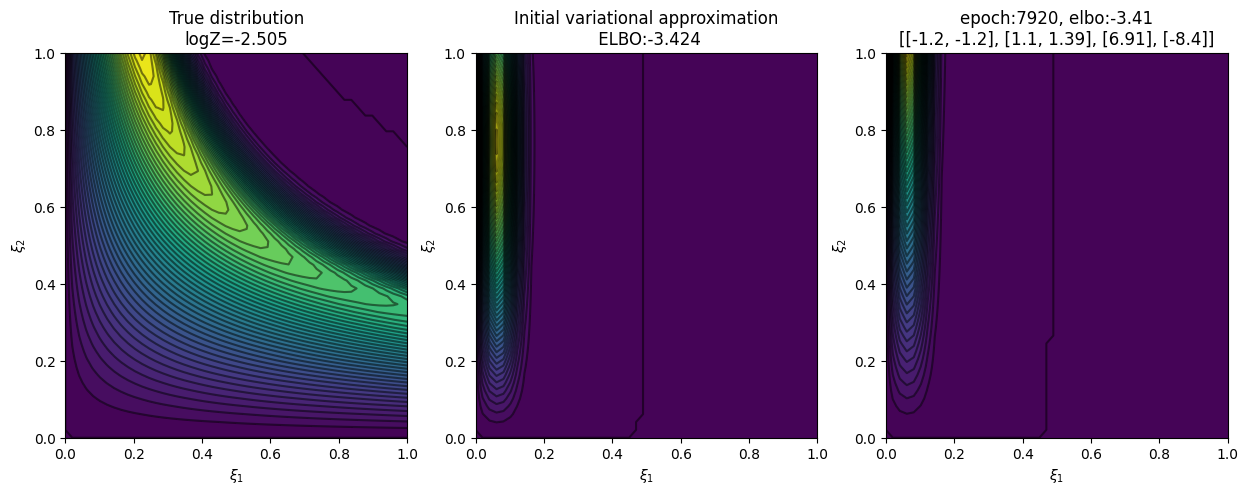

In [11]:
fig, video = meanfield_truncated_gamma_restricted_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


## Experiment 3.2:

In [ ]:
n = 10
k_0 = torch.tensor([3, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([3/10, 3/4]) # need to ensure the first lambda is the smallest
h_0 = 2 * k_0 * lambda_0 - 1

meanfield_truncated_gamma_on_standard_form = MeanFieldTruncatedGammaOn2DStandardForm(
    n=n,
    k_0=k_0,
    lambda_0=lambda_0, 
    lr=0.00005
)
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)


meanfield_truncated_gamma_on_standard_form.run_parameter_optimisation(5000)
fig = meanfield_truncated_gamma_on_standard_form.plot_training_curve();

In [ ]:
fig, video = meanfield_truncated_gamma_on_standard_form.plot_variational_posterior(animate=True);
IPython.display.display(IPython.display.HTML(video))


# $n$-dependencies

In [13]:
from utils import logZ_approx

In [24]:
k_0 = torch.tensor([3, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([1/10, 9/10]) # need to ensure the first lambda is the smallest
h_0 = 2 * k_0 * lambda_0 - 1
lr = 0.001
num_epoch = 1000
print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambda_0.detach(), 2)}\n"
    f"ks_0     = {np.around(k_0.detach(), 2)}\n"
    f"h_0      = {np.around(h_0.detach(), 2)}\n"
#     f"logZ     = {meanfield_truncated_gamma_restricted_on_standard_form.log_evidence():.3f}\n"
)

rec = []
for logn in range(1, 12):
    n = int(10**logn)
    vis = dict(
        mf_gamma=MeanFieldGammaOn2DStandardForm(
            n=n,
            k_0=k_0,
            lambda_0=lambda_0,
            lr=lr, 
            lambdas_grad=False, 
            ks_grad=False, 
            beta1_grad=False,
        ), 
        mf_gamma_trunc=MeanFieldTruncatedGammaOn2DStandardForm(
            n=n,
            k_0=k_0,
            lambda_0=lambda_0, 
            lr=lr, 
            lambdas_grad=False, 
            ks_grad=False, 
            beta1_grad=False,
        ), 
        gaussian=GaussianFamilyOn2DStandardForm(
            n=n,
            k_0=k_0,
            h_0=h_0,
            lr=lr
        )
    )
    for vi_name, vi in vis.items():
        logZ = vi.log_evidence()
        leading_approx = logZ_approx(k_0.numpy(), h_0.numpy(), n)
        elbo_init = vi.elbo_fn().item()
        vi.run_parameter_optimisation(num_epoch, verbose=False)
        elbo = vi.elbo_fn().item()
        print(f"{vi_name:15s}, n={n:12d}, logZ={logZ:.4f} ({leading_approx:.4f}), "
              f"EBLO_0={elbo_init:.4f}, ELBO={elbo:.4f}")
        
        rec.append([vi_name, n, logZ, leading_approx, elbo_init, elbo])

n        = 1000
lambda_0 = tensor([0.1000, 0.9000])
ks_0     = tensor([3, 4])
h_0      = tensor([-0.4000,  6.2000])

mf_gamma       , n=          10, logZ=-1.6436 (0.4538), EBLO_0=-0.8724, ELBO=-0.1527


/home/edmund/variational-approximation-for-singular-models/notebooks/utils.py:96: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return scipy.integrate.quad(_integrand, 0, 1, args=(lmbda, beta, 2))[0] * beta
/home/edmund/variational-approximation-for-singular-models/notebooks/utils.py:71: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return scipy.integrate.quad(_integrand, 0, 1, args=(lmbda, beta, 1))[0] * beta
/home/edmund/.local/share/virtualenvs/variational-approximation-for-singular-mod-T_CFu1la/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in _integrated1 (vectorized)
  outputs = ufunc(*in

mf_gamma_trunc , n=          10, logZ=-1.6436 (0.4538), EBLO_0=-1.7236, ELBO=nan
gaussian       , n=          10, logZ=-1.6436 (0.4538), EBLO_0=-0.6009, ELBO=1.7120
mf_gamma       , n=         100, logZ=-1.8587 (0.2236), EBLO_0=-1.1026, ELBO=-0.3830
mf_gamma_trunc , n=         100, logZ=-1.8587 (0.2236), EBLO_0=-1.9538, ELBO=nan
gaussian       , n=         100, logZ=-1.8587 (0.2236), EBLO_0=-1.1693, ELBO=-1.1468
mf_gamma       , n=        1000, logZ=-2.0866 (-0.0067), EBLO_0=-1.3329, ELBO=-0.6132
mf_gamma_trunc , n=        1000, logZ=-2.0866 (-0.0067), EBLO_0=-2.1841, ELBO=nan
gaussian       , n=        1000, logZ=-2.0866 (-0.0067), EBLO_0=-28.3023, ELBO=-2.5607
mf_gamma       , n=       10000, logZ=-2.3164 (-0.2369), EBLO_0=-1.5631, ELBO=-0.8435
mf_gamma_trunc , n=       10000, logZ=-2.3164 (-0.2369), EBLO_0=-2.4143, ELBO=nan
gaussian       , n=       10000, logZ=-2.3164 (-0.2369), EBLO_0=-93.1601, ELBO=-16.5773
mf_gamma       , n=      100000, logZ=-2.5466 (-0.4672), EBLO_0=-1.7934, 

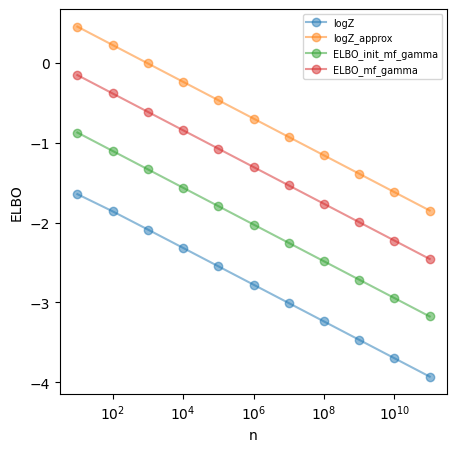

In [25]:
df = pd.DataFrame(rec, index=None)
df.columns = ["name", "n", "logZ", "logZ_approx", "ELBO_init", "ELBO"]
df = df.set_index("name")
fig,ax = plt.subplots(1, 1, figsize=(5, 5))
alpha=0.5
ax.plot(df.loc["mf_gamma", "n"], df.loc["mf_gamma", "logZ"], "o-", label="logZ", alpha=alpha)
ax.plot(df.loc["mf_gamma", "n"], df.loc["mf_gamma", "logZ_approx"], "o-", label="logZ_approx", alpha=alpha)

for name in df.index.unique():
    if name in ["gaussian", "mf_gamma_trunc"]:
        continue
    d = df.loc[name, :]
    ax.plot(df.loc[name, "n"], df.loc[name, "ELBO_init"], "o-", label=f"ELBO_init_{name}", alpha=alpha)
    ax.plot(df.loc[name, "n"], df.loc[name, "ELBO"], "o-", label=f"ELBO_{name}", alpha=alpha)
    
ax.set_xscale('log')
ax.set_xlabel("n")
ax.set_ylabel("ELBO")
ax.legend(fontsize="x-small")

tensor([2.0000, 6.2000])


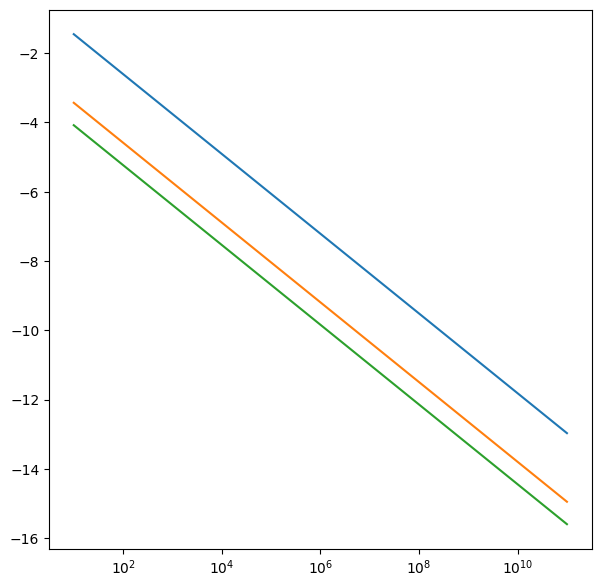

In [25]:
# def elbo_func_mf_gamma_trunc(lambdas, ks, betas, lambda_0, k_0, n):
#     r = k_0 / ks
#     iglambdas_betas = igamma(lambdas, betas)
#     logbetas = torch.log(betas)
#     term1 = n * torch.exp(torch.sum(
#         -r * logbetas
#         + torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
#         + torch.log(torch.igamma(lambdas + r, betas)) - torch.log(iglambdas_betas)
#     ))

#     term2 = torch.sum(
#         torch.log(2 * ks) + lambdas * logbetas 
#         - torch.lgamma(lambdas) - torch.log(iglambdas_betas)
#         - lambdas * (igamma(lambdas + r, betas) / iglambdas_betas)
# #         + (lambdas - r * lambda_0) * (gradigamma(lambdas, betas) / iglambdas_betas - logbetas)
#     )
#     return -term1 - term2

k_0 = torch.tensor([3, 4])  # assume no "flat" dimensions with k_j = 0
lambda_0 = torch.tensor([.5, .9]) # need to ensure the first lambda is the smallest
h_0 = 2 * k_0 * lambda_0 - 1
print(h_0)
rec = []
for logn in range(1, 12):
    n = int(10**logn)
    leading_approx = logZ_approx(k_0.numpy(), h_0.numpy(), n)
    betas = torch.tensor([n, 1], dtype=torch.float)
    elbo1 = elbo_func_mf_gamma(lambda_0, k_0, betas, lambda_0, k_0, n)
    elbo2 = elbo_func_mf_gamma_trunc(lambda_0, k_0, betas, lambda_0, k_0, n)
    rec.append([n, leading_approx, elbo1, elbo2])
    
    
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
x = np.array(rec)
ax.plot(x[:, 0], x[:, 1])
ax.plot(x[:, 0], x[:, 2])
ax.plot(x[:, 0], x[:, 3])
ax.set_xscale('log')

# Experiment 4: Learning high dimension standard form, comparing Generalised Gamma Mean Field Family with Gaussian Family

# Misc

In [ ]:
f = lambda y, x: gaussian_on_standard_form.true_unnormalised_density(torch.tensor([x, y]))
scipy.integrate.dblquad(f, 0, 1, 0, 1)

In [ ]:

class CustomsFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return x**2 + 13 * y
    
    @staticmethod
    def backward(ctx, grad_output):
        x, y = ctx.saved_tensors
        return grad_output * 2 * x, grad_output * 13


In [ ]:
f = CustomsFunc.apply
x = torch.tensor(3., requires_grad=True)
y = torch.tensor(4., requires_grad=True)
z = f(x, y)
z.backward()

x.grad, y.grad

In [ ]:
x = torch.tensor(3., requires_grad=True)
y = torch.tensor(10., requires_grad=True)
z = igamma(x, y)
z.backward()
x.grad, y.grad

In [ ]:
@interact(
    n=(2, 10000), 
    t=(-2.0, 2.0)
)
def _plot_contour(n=50, t=0.5):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    x = np.linspace(-1, 1, num=1000)
    ax.plot(x, np.cos(2 * np.pi * n * (x**4 + t * x)) * (1 - np.exp(-1/x**2)), alpha=0.8)
    ax.plot(x, (1 - np.exp(-1/x**2)), color="r", alpha=0.5)
    ax.plot(x, -(1 - np.exp(-1/x**2)), color="r", alpha=0.5)

In [43]:
x1 = torch.tensor([1.0], requires_grad=False)
x2 = torch.tensor([2.0], requires_grad=True)

optim = torch.optim.Adam([x1, x2], lr=0.1)
for _ in range(10):
    optim.zero_grad()
    x = torch.stack([x1, x2], dim=-1)
#     a = x1**2 + x2**2
    a = torch.sum(x**2)
    a.backward()
    optim.step()
    print(a, x1, x2)

tensor(5., grad_fn=<SumBackward0>) tensor([1.]) tensor([1.9000], requires_grad=True)
tensor(4.6100, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.8002], requires_grad=True)
tensor(4.2406, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.7006], requires_grad=True)
tensor(3.8921, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.6015], requires_grad=True)
tensor(3.5648, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.5030], requires_grad=True)
tensor(3.2589, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.4051], requires_grad=True)
tensor(2.9744, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.3082], requires_grad=True)
tensor(2.7114, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.2123], requires_grad=True)
tensor(2.4698, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.1177], requires_grad=True)
tensor(2.2493, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.0246], requires_grad=True)


In [179]:
def grad_lmbda_lower_incomplete_gamma(lmbda, beta):
    # reference: Eq 25 for derivative of upper incomplete gamma in 
    # http://www.iaeng.org/IJAM/issues_v47/issue_3/IJAM_47_3_04.pdf
    acc = 0
    for k in range(150):
        term1 = torch.log(beta) / (lmbda + k)
        term1 -= 1 / (lmbda + k)**2
        
        logterm2 = (
            (k + lmbda) * torch.log(beta) - torch.lgamma(torch.tensor([k + 1], dtype=torch.float))
        )
        term2 = torch.exp(logterm2)
#         term2 = (k + lmbda) * torch.log(beta) - torch.lgamma(torch.tensor([k + 1], dtype=torch.float)) - torch.log(lmbda + k) 
#         term2 = torch.exp(term2)
        if k % 2 == 1:
            term2 *= -1
        acc += term1 * term2
        
#         print(f"{k:3d}, {term1.item():.5f}, {term2.item():.5f}, {acc.item():.5f}, {(term1 * term2).item():.5f}")
    return acc


x1 = torch.tensor([10.000, 2.0, 3.2])
y1 = torch.tensor([6., 2.0, 1.0])
%time grad_lmbda_lower_incomplete_gamma(x1, y1)

CPU times: user 14 ms, sys: 39 µs, total: 14 ms
Wall time: 13.5 ms


tensor([ 4.8650e+04, -4.2873e-02, -5.5817e-02])

In [180]:
x = x1.numpy()
y = y1.numpy()
def integrand(t, x, y):
    return np.exp(-y * t) * (y * t)**(x-1) * np.log(y * t)
# integrand = lambda t, x, y: np.exp(-y * t) * (y * t)**(x-1) * np.log(y * t)

def f(x, y):
    return scipy.integrate.quad(integrand, 0, 1, args=(x, y))[0] * y

fvec = np.vectorize(f)
# vec_integrand = np.vectorize(integrand)
# %time scipy.integrate.quad(integrand, 0, 1)
%time fvec(x1, y1)

CPU times: user 866 µs, sys: 17 µs, total: 883 µs
Wall time: 889 µs


array([ 4.91165965e+04, -4.28732689e-02, -5.58167725e-02])

In [182]:
grad_lmbda_lower_incomplete_gamma(x1, y1)

tensor([ 4.8650e+04, -4.2873e-02, -5.5817e-02])